Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
ID = ""

---

# Lab 05: Optimization Using Newton's Method

In this lab, we'll explore an alternative to gradient descent
for nonlinear optimization problems: Newton's method.

## Newton's method in one dimension

Consider the problem of finding the *roots* $\textbf{x}$ of a nonlinear function $f: \mathbb{R}^N \rightarrow \mathbb{R}$. A root of $f$ is a point $\mathbf{x}$ that satisfies $f(\mathbf{x}) = 0$.

In one dimension, Newton's method for finding zeroes works as follows:

1. Pick an initial guess $x_0$

2. Let $x_{i+1} = x_i + \frac{f(x_i)}{f'(x_i)}$

3. If not converged, go to #2.

Convergence occurs when $|f(x_i)| < \epsilon_1$ or when $|f(x_{i+1})-f(x_i)| < \epsilon_2$.

Let's see how this works in practice.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

### Example 1: Root finding for cubic polynomial 

In [ ]:
def fx(x, p):
    f_x = np.polyval(p, x)
    return f_x

In [ ]:
n = 200
x = np.linspace(-3, 3, n)  

# Create the polynomial f(x) = x^3 + x^2 
p = np.poly1d([1, 1, 0, 0]) # [x^3, x^2, x^1, 1]

# Derivative of a polynomial
# This is a convenient method to obtain p_d = np.poly1d([3, 2, 0])
p_d = np.polyder(p)
print('p derivative:', p_d)
print('p derivative:', p_d[2], p_d[1], p_d[0])

# Get values for f(x) and f'(x) for graphing purposes
y = fx(x, p)
y_d = fx(x,p_d)

In [ ]:
# Try three possible guesses for x0
x0_arr = [-3.0, 1.0, 3.0]
max_iter = 30
threshold = 0.001
roots = []

fig1 = plt.figure(figsize=(8,8)) 
ax = plt.axes()
plt.plot(x, y, 'g-', label='f(x)')
plt.plot(x, y_d, 'b--', label="f\'(x)")

for x0 in x0_arr:
    # Plot initial data point
    plt.plot(x0, fx(x0,p), '*', label='intial: ' + str(x0))    
    i = 0
    while i < max_iter:
        # x1 = x0 - f(x0)/f'(x0)
        x1 = x0 - fx(x0, p) / fx(x0, p_d)
        # Check for delta (x) less than threshold
        if np.abs(x0 - x1) <= threshold:
            roots.append(round(x1,4))
            break;
        # Plot current root after every 5 iterations
        if i % 5 == 0:
            plt.plot(x1, fx(x1, p), '.', label='iteration '+ str(i+1))
        else:
            plt.plot(x1, fx(x1, p), '.')        
        x0 = x1
        i = i + 1
    plt.plot(x1, fx(x1, p), 'ko', label='converged at iteration '+ str(i+1))

plt.legend(bbox_to_anchor=(1.5, 1.0), loc ='upper right')
plt.title('Example 1: Newton root finding for a polynomial')

plt.show()

#### Example 2: Root finding for sine function

In [ ]:
def fx_sin(x):  
    f_x = np.sin(x)        
    return f_x

def fx_dsin(x):    
    return np.cos(x)

In [ ]:
n = 200

x = np.linspace(-np.pi, np.pi, n)  

# Get f(x) and f'(x) for plotting
y = fx_sin(x)
y_d = fx_dsin(x)

In [ ]:
# Consider three possible starting points
x0_arr = [2.0, 1.0, -2.0]
max_iter = 30
i = 0
threshold = 0.01
roots = []

fig1 = plt.figure(figsize=(10,10)) 
ax = plt.axes()
ax.set_aspect(aspect = 'equal', adjustable = 'box')
plt.plot(x, y, 'g-', label='f(x)')
plt.plot(x, y_d, 'b--', label='df(x)')

for x0 in x0_arr:
    plt.plot(x0, fx_sin(x0), 'bo', label='intial: ' + str(x0))
    i = 0;
    while i < max_iter:
        x1 = x0 - fx_sin(x0) / fx_dsin(x0)
        if np.abs(x0 - x1) <= threshold:
            roots.append(x1)
            plt.plot(x1,fx_sin(x1),'ko',label='converged at iteration '+ str(i))
            break;
        if i % 5 == 0:
            plt.plot(x1, fx_sin(x1), '*', label='iteration '+ str(i+1))
        else:
            plt.plot(x1, fx_sin(x1), '*')        
        x0 = x1
        i = i + 1

plt.legend(bbox_to_anchor=(1.5, 1.0), loc ='upper right')
plt.title('Example 2: Newton root findign for sine function')

plt.show()

print('Roots: %f, %f, %f' % (roots[0], roots[1], roots[2]))


## Newton's method for optimization

Now, consider the problem of minimizing a scalar function $J : \mathbb{R}^n \mapsto \mathbb{R}$.
We would like to find
$$ \theta^* = \text{argmin}_\theta J(\theta) $$
We already know gradient descent:
$$ \theta^{(i+1)} \leftarrow \theta^{(i)} - \alpha \nabla_J(\theta^{(i)}).$$
But Newton's method gives us a potentially faster way to find $\theta^*$ as a zero of
the system of equations
$$\nabla_J(\theta^*) = \mathbf{0}.$$

In one dimension, to find the zero of $f'(x)$, obviously, we would apply Newton's method
to $f'(x)$, obtaining the iteration
$$x_{i+1} = x_i - f'(x_i) / f''(x_i).$$
The multivariate extension of Newton's optimization method is
$$\mathbf{x}_{i+1} = \mathbf{x}_i - \mathtt{H}_f(\mathbf{x}_i) \nabla_f(\mathbf{x}_i),$$
where $\mathtt{H}_f(\mathbf{x})$ is the *Hessian* of $f$ evaluated at $\textbf{x}$:
$$\mathtt{H}_f(\mathbf{x}) = \begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 x_2} & \cdots & \frac{\partial^2 f}{\partial x_1 x_n} \\
\frac{\partial^2 f}{\partial x_2 x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2 x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n x_1} & \frac{\partial^2 f}{\partial x_n x_2} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}$$

This means, for the minimization of $J(\theta)$, we would obtain the update rule
$$\theta^{(i+1)} \leftarrow \theta^{(i)} - \mathtt{H}_J(\theta^{(i)}) \nabla_J(\theta^{(i)}).$$


## Application to logistic regression

Let's create some difficult sample data as follows:

**Class 1:** Two features $x_1$ and $x_2$ jointly distributed as a two-dimensional spherical Gaussian with parameters

$$\mu = \begin{bmatrix} x_{1c} \\ x_{2c} \end{bmatrix},
\Sigma = \begin{bmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_1^2 \end{bmatrix}.$$

**Class 2:** Two features $x_1$ and $x_2$ in which the data are generated by first sampling an angle $\theta$ according to a uniform distribution, sampling a distance $d$ according to a one-dimensional Gaussian with a mean of $(3\sigma_1)^2$ and a variance of $(\frac{1}{2}\sigma_1)^2$, then outputting the point $$\textbf{x} = \begin{bmatrix} x_{1c} + d \cos\theta \\ x_{2c} + d \sin\theta \end{bmatrix}$$.

Generate 100 samples for each of the classes.

### Exercise 1.1 (5 points)

Generate data for class 1 with 100 samples

$$\mu = \begin{bmatrix} x_{1c} \\ x_{2c} \end{bmatrix},
\Sigma = \begin{bmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_1^2 \end{bmatrix}.$$

<details>
    <summary><font size="3" color="green"><b>Hint:</b></font></summary>
    You can use <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html">numpy.random.multivariate_normal</a> to generate samples.
</details>

In [ ]:
mu_1 = np.array([1.0, 2.0])
sigma_1 = 1
num_sample = 100

cov_mat = None
X1 = None

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print(X1[:5])

# Test function: Do not remove
assert X1.shape == (100, 2), 'Size of X1 is incorrect'
assert cov_mat.shape == (2, 2), 'Size of x_test is incorrect'
count = 0 
for i in range(2):
    for j in range(2):
        if i==j and cov_mat[i,j] != 0:
            if cov_mat[i,j] == sigma_1:
                count += 1
        else:
            if cov_mat[i,j] == 0:
                count += 1
assert count == 4, 'cov_mat data is incorrect'

print("success!")
# End Test function

**Expect result (or looked alike):**\
[[-0.48508229  2.65415886]\
 [ 1.17230227  1.61743589]\
 [-0.61932146  3.53986541]\
 [ 0.70583088  1.45944356]\
 [-0.93561505  0.2042285 ]]

### Exercise 1.2 (5 points)

Generate data for class 2 with 100 samples

$$\textbf{x} = \begin{bmatrix} x_{1c} + d \cos\theta \\ x_{2c} + d \sin\theta \end{bmatrix}$$.

with a mean of $(3\sigma_1)^2$ and a variance of $(\frac{1}{2}\sigma_1)^2$

<details>
    <summary><font size="3" color="green"><b>Hint:</b></font></summary>
    You can use <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html">numpy.random.uniform</a> and/or <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html">numpy.random.normal</a> to generate samples.
</details>

In [ ]:
# 1. Create sample angle from 0 to 2pi with 100 samples
angle = None
# 2. Create sample with normal distribution of d with mean and variance
d =  None
# 3 Create X2
X2 = None

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('angle:',angle[:5])
print('d:', d[:5])
print('X2:', X2[:5])

# Test function: Do not remove
assert angle.shape == (100,) or angle.shape == (100,1) or angle.shape == 100, 'Size of angle is incorrect'
assert d.shape == (100,) or d.shape == (100,1) or d.shape == 100, 'Size of d is incorrect'
assert X2.shape == (100,2), 'Size of X2 is incorrect'
assert angle.min() >= 0 and angle.max() <= 2*np.pi, 'angle generate incorrect'
assert d.min() >= 8 and d.max() <= 10, 'd generate incorrect'
assert X2[:,0].min() >= -13 and X2[:,0].max() <= 13, 'X2 generate incorrect'
assert X2[:,1].min() >= -10 and X2[:,1].max() <= 13.5, 'X2 generate incorrect'

print("success!")
# End Test function

**Expect result (or looked alike):**\
angle: [4.77258271 3.19733552 0.71226709 2.11244845 6.06280915]\
d: [9.13908279 8.84218552 9.24427852 8.74831667 8.85727588]\
X2: [[ 0.064701   -6.46837219]\
 [-7.65614929  1.12480234]\
 [ 6.37750805  9.58147629]\
 [-3.80438416  8.95550952]\
 [ 7.70745021 -1.73194274]]

### Exercise 1.3 (5 points)

Combine X1 and X2 into single dataset

In [ ]:
# 1. concatenate X1, X2 together
X = None
# 2. Create y with class 1 as 0 and class 2 as 1
y = None

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print("shape of X:", X.shape)
print("shape of y:", y.shape)

# Test function: Do not remove
assert X.shape == (200, 2), 'Size of X is incorrect'
assert y.shape == (200,) or y.shape == (200,1) or y.shape == 200, 'Size of y is incorrect'
assert y.min() == 0 and y.max() == 1, 'class type setup is incorrect'

print("success!")
# End Test function

**Expect result (or looked alike):**\
shape of X: (200, 2)\
shape of y: (200, 1)

### Exercise 1.4 (5 points)

Plot the graph between class1 and class2 with **difference color and point style**.

In [ ]:
fig1 = plt.figure(figsize=(8,8))
ax = plt.axes() 
plt.title('Sample data for classification problem')
plt.grid(axis='both', alpha=.25)
# plot graph here
# YOUR CODE HERE
raise NotImplementedError()
# end plot graph
plt.axis('equal')
plt.show()

**Expect result (or looked alike):**

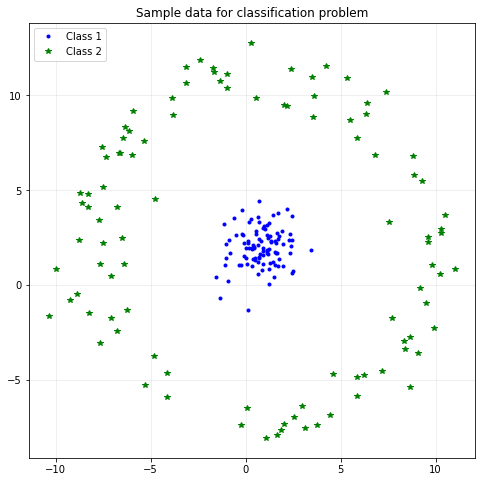

### Exercise 1.5 (5 points)

Split data into training and test datasets with 80% of training set and 20% of test set

In [ ]:
train_size = 0.8

idx_train = None
idx_test = None

X_train = None
X_test = None
y_train = None
y_test = None

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('idx_train:', idx_train[:10])
print("train size, X:", X_train.shape, ", y:", y_train.shape)
print("test size,  X:", X_test.shape,  ", y:", y_test.shape)

# Test function: Do not remove
assert X_train.shape == (160, 2), 'Size of X_train is incorrect'
assert y_train.shape == (160,) or y_train.shape == (160,1) or y.shape == 160, 'Size of y_train is incorrect'
assert X_test.shape == (40, 2), 'Size of X_test is incorrect'
assert y_test.shape == (40,) or y_test.shape == (40,1) or y.shape == 40, 'Size of y_test is incorrect'

print("success!")
# End Test function

**Expect reult (Or looked alike):**\
idx_train: [ 78  61  28 166  80 143   6  76  98 133]\
train size, X: (160, 2) , y: (160, 1) \
test size,  X: (40, 2) , y: (40, 1)

### Exercise 1.6 (5 points)

Write the function which normalize X set

#### Practice yourself (No grade, but has extra score 3 points)

Try to use Jupyter notebook to write the normalize equation.

YOUR ANSWER HERE

In [ ]:
def normalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    X_norm = None
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return X_norm

In [ ]:
XX = normalization(X)

X_train_norm = XX[idx_train]
X_test_norm = XX[idx_test]

# Add 1 at the first column of training dataset (for bias) and use it when training
X_design_train = np.insert(X_train_norm,0,1,axis=1)
X_design_test = np.insert(X_test_norm,0,1,axis=1)

m,n = X_design_train.shape

print(X_train_norm.shape)
print(X_design_train.shape)
print(X_test_norm.shape)
print(X_design_test.shape)

# Test function: Do not remove
assert XX[:,0].min() >= -2.5 and XX[:,0].max() <= 2.5, 'Does the XX is normalized?'
assert XX[:,1].min() >= -2.5 and XX[:,1].max() <= 2.5, 'Does the XX is normalized?'

print("success!")
# End Test function

### Exercise 1.7 (10 points)

define class for logistic regression: batch gradient descent

The class includes:

 - **Sigmoid** function $$sigmoid(z) = \frac{1}{1+e^{-z}}$$
 - **Softmax** function $$softmax(z) = \frac{e^{z_i}}{\sum_n{e^z}}$$
 - **Hyperthesis (h)** function $$\hat{y} = h(X;\theta) = softmax(\theta . X)$$
 - **Gradient (Negative likelihood)** function $$gradient = - X . \frac{y-\hat{y}}{n}$$
 - **Cost** function $$cost = \frac{\sum{((-y\log{\hat{y}}) - ((1-y)\log{(1 - \hat{y})})})}{n}$$
 - **Gradient ascent** function
 - **Prediction** function
 - **Get accuracy** funciton

In [ ]:
class Logistic_BGD:
    def __init__(self):
        pass
    
    def sigmoid(self,z):
        s = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return s

    def softmax(self, z):
        sm = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return sm
    
    def h(self,X, theta):
        hf = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return hf
    
    def gradient(self, X, y, y_pred):
        grad = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return grad
        
    def costFunc(self, theta, X, y):
        cost = None
        grad = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return cost, grad
    
    def gradientAscent(self, X, y, theta, alpha, num_iters):
        m = len(y)
        J_history = []
        theta_history = []
        for i in range(num_iters):
            # 1. calculate cost, grad function
            cost, grad = None, None
            # 2. update new theta
            #theta = None
            # YOUR CODE HERE
            raise NotImplementedError()
            
            
            J_history.append(cost)
            theta_history.append(theta)
        J_min_index = np.argmin(J_history)
        print("Minimum at iteration:",J_min_index)
        return theta_history[J_min_index] , J_history

    def predict(self,X, theta):
        labels=[]
        # 1. take y_predict from hyperthesis function
        # 2. classify y_predict that what it should be class1 or class2
        # 3. append the output from prediction
        # YOUR CODE HERE
        raise NotImplementedError()
        
        labels=np.asarray(labels)
        return labels
     
    def getAccuracy(self,X,y,theta):
        percent_correct = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return percent_correct

In [ ]:
# Test function: Do not remove
lbgd = Logistic_BGD()
test_x = np.array([[1,2,3,4,5]]).T
out_x1 = lbgd.sigmoid(test_x)
out_x2 = lbgd.sigmoid(test_x.T)
print('out_x1', out_x1.T)
assert np.array_equal(np.round(out_x1.T, 5), np.round([[0.73105858, 0.88079708, 0.95257413, 0.98201379, 0.99330715]], 5)), "sigmoid function is incorrect"
assert np.array_equal(np.round(out_x2, 5), np.round([[0.73105858, 0.88079708, 0.95257413, 0.98201379, 0.99330715]], 5)), "sigmoid function is incorrect"
out_x1 = lbgd.softmax(out_x1)
out_x2 = lbgd.softmax(out_x2)
print('out_x1', out_x1.T)
assert np.array_equal(np.round(out_x1.T, 5), np.round([[0.16681682, 0.19376282, 0.20818183, 0.21440174, 0.21683678]], 5)), "softmax function is incorrect"
assert np.array_equal(np.round(out_x2, 5), np.round([[0.16681682, 0.19376282, 0.20818183, 0.21440174, 0.21683678]], 5)), "softmax function is incorrect"
test_t = np.array([[0.3, 0.2]]).T
test_x = np.array([[1,2,3,4,5, 6], [2, 9, 4, 3, 1, 0]]).T
test_y = np.array([[0,1,0,1,0,1]]).T
test_y_p = lbgd.h(test_x, test_t)
print('test_y_p', test_y_p.T)
assert np.array_equal(np.round(test_y_p.T, 5), np.round([[0.66818777, 0.9168273, 0.84553473, 0.85814894, 0.84553473, 0.85814894]], 5)), "hyperthesis function is incorrect"
test_g = lbgd.gradient(test_x, test_y, test_y_p)
print('test_g', test_g.T)
assert np.array_equal(np.round(test_g.T, 5), np.round([[0.9746016, 0.73165696]], 5)), "gradient function is incorrect"
test_c, test_g = lbgd.costFunc(test_t, test_x, test_y)
print('test_c', test_c.T)
assert np.round(test_c, 5) == np.round(0.87192491, 5), "costFunc function is incorrect"
test_t_out , test_j = lbgd.gradientAscent(test_x, test_y, test_t, 0.001, 3)
print('test_t_out', test_t_out.T)
print('test_j', test_j)
assert np.array_equal(np.round(test_t_out.T, 5), np.round([[0.29708373, 0.19781153]], 5)), "gradientAscent function is incorrect"
assert np.round(test_j[2], 5) == np.round(0.86896665, 5), "gradientAscent function is incorrect"
test_l = lbgd.predict(test_x, test_t)
print('test_l', test_l)
assert np.array_equal(np.round(test_l, 1), np.round([1,1,1,1,1,1], 1)), "gradientAscent function is incorrect"
test_a = lbgd.getAccuracy(test_x,test_y,test_t)
print('test_a', test_a)
assert np.round(test_a, 1) == 50.0, "getAccuracy function is incorrect"

print("success!")
# End Test function

**Expect result:**\
out_x1 [[0.73105858 0.88079708 0.95257413 0.98201379 0.99330715]]\
out_x1 [[0.16681682 0.19376282 0.20818183 0.21440174 0.21683678]]\
test_y_p [[0.66818777 0.9168273  0.84553473 0.85814894 0.84553473 0.85814894]]\
test_g [[0.9746016  0.73165696]]\
test_c [0.87192491]\
Minimum at iteration: 2\
test_t_out [[0.29708373 0.19781153]]\
test_j [array([0.87192491]), array([0.87044176]), array([0.86896665])]\
test_l [1 1 1 1 1 1]\
test_a 50.0

### Exercise 1.8 (5 points)

Training the data using Logistic_BGD class.
 - Input: X_design_train
 - Output: y_train
 - Use 50,000 iterations
 
Find the initial_theta yourself

In [ ]:
alpha = 0.001
iterations = 50000

BGD_model = None
initial_theta = None
bgd_theta, bgd_cost = None, None

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print(bgd_theta)
print(len(bgd_cost))

print(bgd_cost[0])
plt.plot(bgd_cost)
plt.show()

# Test function: Do not remove
assert bgd_theta.shape == (X_train.shape[1] + 1,1) or bgd_theta.shape == (X_train.shape[1] + 1,) or bgd_theta.shape == X_train.shape[1] + 1, "theta shape is incorrect"
assert len(bgd_cost) == iterations, "cost data size is incorrect"

print("success!")
# End Test function

**Expect result (or look alike):**\
[[-0.07328673]\
 [-0.13632896]\
 [ 0.05430939]]\
50000

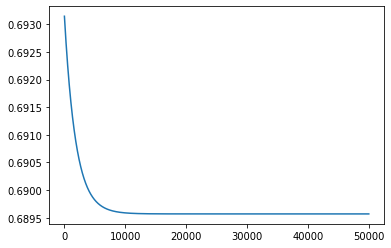

## In lab exercises

1. Verify that the gradient descent solution is correct. Plot the optimal decision boundary you obtain.

2. Write a new class that uses Newton's method for the optmization rather than simple gradient descent.

3. Verify that you obtain a similar solution with Newton's method. Plot the optimal decision boundary you obtain.

4. Compare the number of iterations required for gradient descent vs. Newton's method. Do you observe other issues
   with Newton's method such as a singular or nearly singular Hessian matrix?


### Exercise 1.9 (5 points)

Plot the optimal decision boundary of gradient ascent

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**Expect result (or look alike):**\
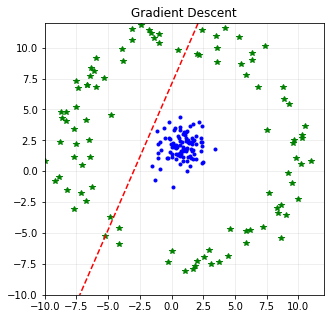

In [ ]:
print("Accuracy =",BGD_model.getAccuracy(X_design_test,y_test,bgd_theta))

### Exercise 2.1 (10 points)

Write Newton's method class

In [ ]:
class Logistic_NM: #logistic regression for newton's method
      
    def __init__(self):
        pass
    
    def sigmoid(self,z):
        s = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return s

    def h(self,X, theta):
        hf = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return hf

    def gradient(self, X, y, y_pred):
        grad = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return grad
        
    def hessian(self, X, y, theta):
        hess_mat = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return hess_mat
        
    def costFunc(self, theta, X, y):   
        cost, grad = None, None
        # YOUR CODE HERE
        raise NotImplementedError()
        return cost, grad
    
    def newtonsMethod(self, X, y, theta, num_iters):
        m = len(y)
        J_history = []
        theta_history = []
        for i in range(num_iters):
            # YOUR CODE HERE
            raise NotImplementedError()
            
            J_history.append(cost)
            theta_history.append(theta)
        J_min_index = np.argmin(J_history)
        print("Minimum at iteration:", J_min_index)
        return theta_history[J_min_index] , J_history

    def predict(self,X, theta):
        labels=[]
        # YOUR CODE HERE
        raise NotImplementedError()
        
        labels=np.asarray(labels)
        return labels
     
    def getAccuracy(self,X,y,theta):
        percent_correct = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return percent_correct

In [ ]:
# Test function: Do not remove
lbgd = Logistic_NM()
test_x = np.array([[1,2,3,4,5]]).T
out_x1 = lbgd.sigmoid(test_x)
out_x2 = lbgd.sigmoid(test_x.T)
print('out_x1', out_x1.T)
assert np.array_equal(np.round(out_x1.T, 5), np.round([[0.73105858, 0.88079708, 0.95257413, 0.98201379, 0.99330715]], 5)), "sigmoid function is incorrect"
assert np.array_equal(np.round(out_x2, 5), np.round([[0.73105858, 0.88079708, 0.95257413, 0.98201379, 0.99330715]], 5)), "sigmoid function is incorrect"
test_t = np.array([[0.3, 0.2]]).T
test_x = np.array([[1,2,3,4,5, 6], [2, 9, 4, 3, 1, 0]]).T
test_y = np.array([[0,1,0,1,0,1]]).T
test_y_p = lbgd.h(test_x, test_t)
print('test_y_p', test_y_p.T)
assert np.array_equal(np.round(test_y_p.T, 5), np.round([[0.66818777, 0.9168273, 0.84553473, 0.85814894, 0.84553473, 0.85814894]], 5)), "hyperthesis function is incorrect"
test_g = lbgd.gradient(test_x, test_y, test_y_p)
print('test_g', test_g.T)
assert np.array_equal(np.round(test_g.T, 5), np.round([[0.9746016, 0.73165696]], 5)), "gradient function is incorrect"
test_h = lbgd.hessian(test_x, test_y, test_t)
print('test_h', test_h)
assert test_h.shape == (2, 2), "hessian matrix function is incorrect"
assert np.array_equal(np.round(test_h.T, 5), np.round([[12.17334371, 6.55487738],[ 6.55487738, 14.84880387]], 5)), "hessian matrix function is incorrect"
test_c, test_g = lbgd.costFunc(test_t, test_x, test_y)
print('test_c', test_c.T)
assert np.round(test_c, 5) == np.round(0.87192491, 5), "costFunc function is incorrect"
test_t_out , test_j = lbgd.newtonsMethod(test_x, test_y, test_t, 3)
print('test_t_out', test_t_out.T)
print('test_j', test_j)
assert np.array_equal(np.round(test_t_out.T, 5), np.round([[0.14765747, 0.15607017]], 5)), "newtonsMethod function is incorrect"
assert np.round(test_j[2], 5) == np.round(0.7534506190845247, 5), "newtonsMethod function is incorrect"
test_l = lbgd.predict(test_x, test_t)
print('test_l', test_l)
assert np.array_equal(np.round(test_l, 1), np.round([1,1,1,1,1,1], 1)), "gradientAscent function is incorrect"
test_a = lbgd.getAccuracy(test_x,test_y,test_t)
print('test_a', test_a)
assert np.round(test_a, 1) == 50.0, "getAccuracy function is incorrect"

print("success!")
# End Test function

**Expect result:**
out_x1 [[0.73105858 0.88079708 0.95257413 0.98201379 0.99330715]]\
test_y_p [[0.66818777 0.9168273  0.84553473 0.85814894 0.84553473 0.85814894]]\
test_g [[0.9746016  0.73165696]]\
test_h [[12.17334371  6.55487738]\
 [ 6.55487738 14.84880387]]\
test_c 0.8719249134773479\
Minimum at iteration: 2\
test_t_out [[0.14765747 0.15607017]]\
test_j [0.8719249134773479, 0.7967484437157274, 0.7534506190845247]\
test_l [1 1 1 1 1 1]\
test_a 50.0

In [ ]:
NM_model = Logistic_NM()

iterations = 1000

nm_theta, nm_cost = NM_model.newtonsMethod(X_design_train, y_train, initial_theta, iterations)
print("theta:",nm_theta)

print(nm_cost[0])
plt.plot(nm_cost)
plt.show()

**Expect result (or look alike):**\
Minimum at iteration: 999\
theta: [[-0.07313861]\
 [-0.13605172]\
 [ 0.05419746]]\
0.6931471805599453

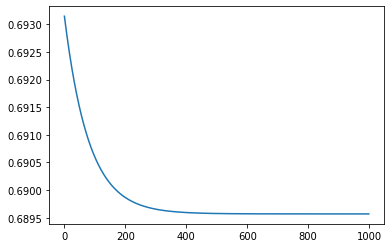

### Exercise 2.2 (5 points)

Plot the optimal decision boundary of Newton method

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**Expect result (or look alike):**

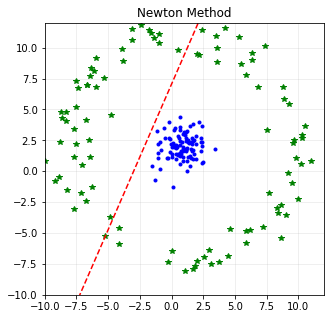

In [ ]:
print("Accuracy =",NM_model.getAccuracy(X_design_test,y_test,bgd_theta))

### Exercise 2.3 (5 points)

Compare the number of iterations required for gradient descent vs. Newton's method. Do you observe other issues with Newton's method such as a singular or nearly singular Hessian matrix?

YOUR ANSWER HERE

## Take-home exercises

1. Perform a *polar transformation* on the data above to obtain a linearly separable dataset. (5 points)

2. Verify that you obtain good classification accuracy for logistic regression with GD or Netwon's method
   after the polar transformation (10 points)
   
3. Apply Newton's method to the dataset you used for the take home exercises in Lab 03. (20 points)




## The report

Write a brief report covering your experiments (both in lab and take home) and send as a Jupyter notebook
to the TAs, Manish and Abhishek before the next lab.

In your solution, be sure to follow instructions.